In [1]:
# Imports
import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pandas as pd
import os
from skimage import io

In [2]:
# TB dataloader
class TBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

In [3]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

In [4]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )        # 224*224*8
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )        # 224*224*16
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )        # 224*224*32
        self.conv4 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(2, 2),
            padding=(1, 1),
        )        # 112*112*64
        self.fc1 = nn.Linear(25088, num_classes)
#         self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
#         x = F.relu(self.conv4(x))
#         x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
        return x

In [5]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device = torch.device("cuda")
device

device(type='cuda')

In [7]:
# Hyperparameters
in_channels = 1    # since the data is grayscale
num_classes = 3    # normal and TB
learning_rate = 0.001
batch_size = 32
num_epochs = 20

In [8]:
dataset = TBDataset(
    csv_file=r"datasets\pneumonia.csv",
    root_dir=r"datasets\pneumonia",
    transform=transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((224, 224)),
         transforms.RandomAdjustSharpness(sharpness_factor=2),
         transforms.RandomAutocontrast(),
         transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor(),]),
    )
len(dataset)

5856

In [9]:
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*.8), (len(dataset) - int(len(dataset)*.8))])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True) 

In [10]:
# Model
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Training
for epoch in range(num_epochs):
    print(epoch)
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")

0


  0%|          | 0/147 [00:00<?, ?it/s]

1


  0%|          | 0/147 [00:00<?, ?it/s]

2


  0%|          | 0/147 [00:00<?, ?it/s]

3


  0%|          | 0/147 [00:00<?, ?it/s]

4


  0%|          | 0/147 [00:00<?, ?it/s]

5


  0%|          | 0/147 [00:00<?, ?it/s]

6


  0%|          | 0/147 [00:00<?, ?it/s]

7


  0%|          | 0/147 [00:00<?, ?it/s]

8


  0%|          | 0/147 [00:00<?, ?it/s]

9


  0%|          | 0/147 [00:00<?, ?it/s]

10


  0%|          | 0/147 [00:00<?, ?it/s]

11


  0%|          | 0/147 [00:00<?, ?it/s]

12


  0%|          | 0/147 [00:00<?, ?it/s]

13


  0%|          | 0/147 [00:00<?, ?it/s]

14


  0%|          | 0/147 [00:00<?, ?it/s]

15


  0%|          | 0/147 [00:00<?, ?it/s]

16


  0%|          | 0/147 [00:00<?, ?it/s]

17


  0%|          | 0/147 [00:00<?, ?it/s]

18


  0%|          | 0/147 [00:00<?, ?it/s]

19


  0%|          | 0/147 [00:00<?, ?it/s]

Accuracy on training set: 97.03


In [12]:
print(f"Test set accuracy: {check_accuracy(test_loader, model)*100:.2f}")

Test set accuracy: 76.28


0 is Normal and 1 is bacterial pneumonia and 2 is viral pneumonia


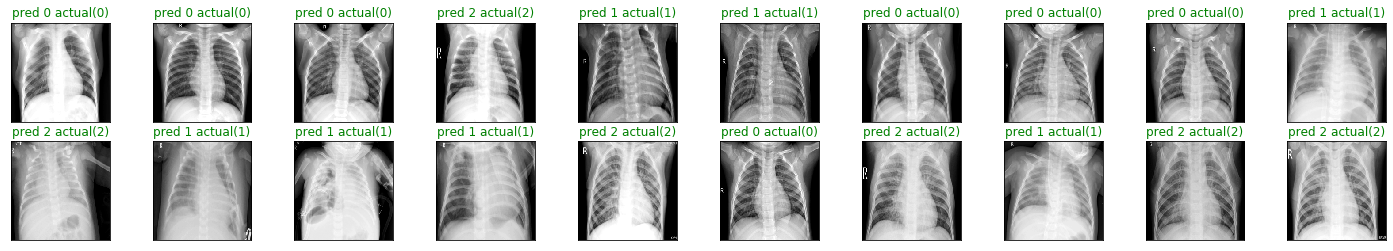

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device=device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = output.max(1)
# prep images for display
images = images.cpu()
print("0 is Normal and 1 is bacterial pneumonia and 2 is viral pneumonia")
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("pred {} actual({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))
